In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st 
import sklearn.linear_model as slm 
import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots
from pyDOE import *
#from numba import autojit #for paralellization
from mpl_toolkits.axes_grid1 import make_axes_locatable

#pull in the classes to do the sims!
import AMPmodule

trialcolz=['teal','tan']

short_outz_labels=['PE','mean VL1','std dev VL1','mean IC50','std dev IC50']
long_outz_labels=['prevention efficacy (%)',
                  'mean VL1 log10(copies/mL)',
                  'std dev VL1 log10(copies/mL)',
                  'mean IC50 log10($\mu$g/mL)',
                  'std dev IC50 log10($\mu$g/mL)']

short_varz_labels=[r'$\log_{10}\phi$',r'$f$',r'$\log_{10}x_{50}$',r'$A_0$']
long_varz_labels=[r'potency reduction factor, $\log_{10}\phi$',
                  r'resistant fraction, $f$',
                  r'maximum IC50 $\log_{10}x_{50}$',
                  r'initial number infected cells $A_0$']

#standardize limits/ticks
ytickz=[[0,0.25,0.5,0.75,1],
       [0,1,2,3,4,5,6,7],
       [1,2,3],
       [-1,0,1,2],
       [0,1,2]]

xtickz=[[0,1,2,3],
       [0,0.2,0.4,0.6,0.8,1],
       [2,3,4],
       [0,5,10,15,20]]

#function to analyze output from a trial simultaion
def analyze_out(trial_list,tr_ctl):
    nts=len(trial_list)
    PE=np.zeros([nts])
    fpvls_avg=np.zeros([nts]); fpvls_std=np.zeros([nts]);
    IC50s_avg=np.zeros([nts]); IC50s_std=np.zeros([nts]);

    for it in range(nts):
        tr=trial_list[it]
        fpvls=np.log10(tr.fp_vs[tr.fp_vs>0])
        fpis=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2 #first positive indicies
        fpts=tr.fp_ts[tr.fp_vs>0]

        #rescale the IC50 so it matches what will be measured in vitro
        IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
        IC50s[IC50s>np.log10(50)]=np.log10(50)

        #now trial summary outcomes
        PE[it]=1-sum(tr.fp_vs>0)/np.sum(tr_ctl.brks>0)

        fpvls_avg[it]=np.nanmean(fpvls)
        fpvls_std[it]=np.nanstd(fpvls)

        IC50s_avg[it]=np.nanmean(IC50s)
        IC50s_std[it]=np.nanstd(IC50s)

    outcomes=np.array([PE,fpvls_avg,fpvls_std,IC50s_avg,IC50s_std])

    return outcomes

In [2]:
#loop to make heatmaps for f and phi

nts=10 #number of trials
Nps=100 #number of exposures per trial

iv=np.logspace(0,3,nts) #potency factor
rf=np.linspace(0.10,1,nts) #resistant fraction, never less than 10%

%time tr_ctl=AMPmodule.trial(name='ctl', nps=Nps, tF=560, dose=0, clade='bimodal', rfrac=0.1, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)

dose=10
list_tr2=[];
for iit1 in range(nts):
    for iit2 in range(nts):
        l2_out = AMPmodule.trial(name='D_'+str(dose)+'_'+str(iit2), nps=Nps, tF=560, 
                           dose=dose, clade='bimodal', 
                           rfrac=rf[iit1], A0=1, iv_phi=iv[iit2], maxIC50=100, 
                               v_flg=False, keep_flg=0)
        list_tr2.append(l2_out)
    print(iit1)


CPU times: user 53.3 s, sys: 306 ms, total: 53.6 s
Wall time: 53.4 s
0
1
2
3
4
5
6
7
8
9


In [3]:
#analyze
gog=analyze_out(list_tr2,tr_ctl)#analyze trial sims

#make a list of all params
allparams=[]
allparams=[]
for iit1 in range(nts):
    for iit2 in range(nts):
        allparams.append([iv[iit2],rf[iit1]])


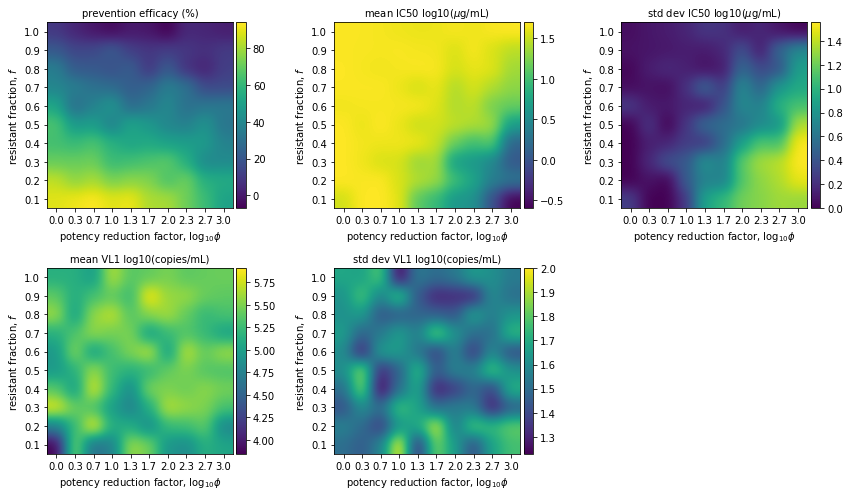

In [17]:
#loop through and make heatmaps
plt.figure(figsize=(12,7))
oi=[1,4,5,2,3]
for o in range(len(short_outz_labels)):
    plt.subplot(2,3,oi[o])
    pout=np.zeros([nts,nts])
    for iit1 in range(nts):
        for iit2 in range(nts):
            if o==0:
                cc=100
            else:
                cc=1
            pout[iit2,iit1]=cc*gog[o,iit1+nts*iit2]
    im=plt.imshow(pout,origin='lower',interpolation='gaussian')#vmin=min(ytickz[o]),vmax=max(ytickz[o]))
    plt.xticks(range(nts),np.round(np.log10(iv),1),fontsize=10)
    plt.yticks(range(nts),np.round(rf,1),fontsize=10)
    plt.xlabel(long_varz_labels[0])
    plt.ylabel(long_varz_labels[1])
    plt.title(long_outz_labels[o],fontsize=10)
    
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cb=plt.colorbar(im, cax=cax)
    #cb.ax.set_ylabel(long_outz_labels[o],fontsize=10)

plt.tight_layout()
plt.savefig('figures/global/heatmaps_smooth.pdf',dpi=600)


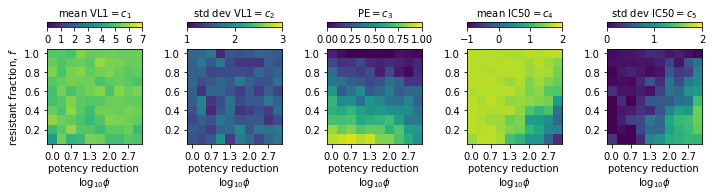

In [18]:
#loop through and make heatmaps - 1 line
plt.figure(figsize=(10,3))
titstr=[r'$=c_1$',r'$=c_2$',r'$=c_3$',r'$=c_4$',r'$=c_5$']

oind=1
for o in [1,2,0,3,4]:#range(len(short_outz_labels)):
    plt.subplot(1,5,oind)
    pout=np.zeros([nts,nts])
    for iit1 in range(nts):
        for iit2 in range(nts):
            pout[iit2,iit1]=cc*gog[o,iit1+nts*iit2]
    im=plt.imshow(pout,origin='lower',vmin=min(ytickz[o]),vmax=max(ytickz[o]))#,interpolation='gaussian')
    plt.xticks(np.arange(nts)[::2],np.round(np.log10(iv),1)[::2],fontsize=10)
    plt.yticks(np.arange(nts)[1::2],np.round(rf,1)[1::2],fontsize=10)
    #plt.ylim([0,10])
    if oind==1:
        plt.ylabel(long_varz_labels[1])
    #else:
        #plt.yticks(range(nts),['']*10)
    plt.xlabel('potency reduction \n'+short_varz_labels[0])
    #plt.title(short_outz_labels[o],fontsize=10)
    
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('top', size="5%", pad=0.3)

    cb=plt.colorbar(im, cax=cax, orientation='horizontal', ticks=ytickz[o])
    cb.ax.set_title(short_outz_labels[o]+titstr[oind-1],fontsize=10)
    #cb.ax.set_zticks(fontsize=8)
    oind+=1

plt.tight_layout()
plt.savefig('figures/global/heatmaps.pdf',dpi=600)


[100.0, 0.4]
[0.50588235 5.4990251  1.36129614 1.17528445 0.88301273]


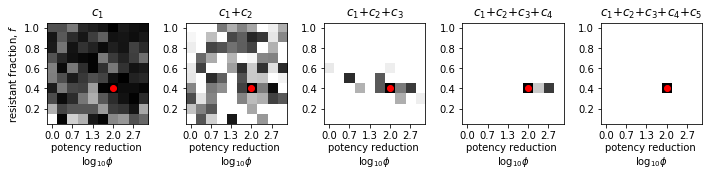

In [32]:
#make a plot that zeros in on the variables

#pick a random (sort of interesting? -- medium?) parameter set
rfi=3; phii=6
trind=phii+nts*rfi #index of that trial
parzi=allparams[trind]
print(parzi)

#get the outcomes of that trial
outi=gog[:,trind]
print(outi)

thresh=0.2

titstr=[r'$c_1$',r'$c_1$+$c_2$',r'$c_1$+$c_2$+$c_3$',r'$c_1$+$c_2$+$c_3$+$c_4$',r'$c_1$+$c_2$+$c_3$+$c_4$+$c_5$']
#loop through and make heatmaps
plt.figure(figsize=(10,3))
redmat=np.zeros([nts,nts])
oind=1
for o in [1,2,0,3,4]:#range(len(short_outz_labels)):
    plt.subplot(1,5,oind)#oi[o])
    pout=np.zeros([nts,nts])
    for iit1 in range(nts):
        for iit2 in range(nts):
            pouti=gog[o,iit1+nts*iit2]            
            pcterr=np.abs(pouti-outi[o])/outi[o]
            if pcterr>thresh:
                redmat[iit2,iit1]=1
            else:
                if redmat[iit2,iit1]<pcterr:
                    redmat[iit2,iit1]=pcterr
    im=plt.imshow(redmat,origin='lower',vmin=0,vmax=thresh,cmap='gray')
    plt.xticks(np.arange(nts)[::2],np.round(np.log10(iv),1)[::2],fontsize=10)
    plt.yticks(np.arange(nts)[1::2],np.round(rf,1)[1::2],fontsize=10)
    plt.xlabel('potency reduction \n'+short_varz_labels[0])
    if oind==1:
        plt.ylabel(long_varz_labels[1])
    plt.scatter(phii,rfi,color='red',marker='o')
    plt.title(titstr[oind-1],fontsize=12)
    #plt.title(short_outz_labels[o],fontsize=10)
    oind+=1
    
plt.tight_layout()
plt.savefig('figures/global/heatmapsred_thresh'+str(thresh)+'_'+str(phii)+'_'+str(rfi)+'.pdf',dpi=600)


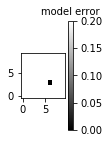

In [31]:
plt.figure(figsize=(1,2))
plt.imshow(redmat,origin='lower',vmin=0,vmax=thresh,cmap='gray')
cb=plt.colorbar(ticks=[0,0.05,0.1,0.15,0.2])
cb.ax.set_title('model error',fontsize=10)
plt.savefig('figures/global/heatmapsred_thresh_ebar.pdf',dpi=600)


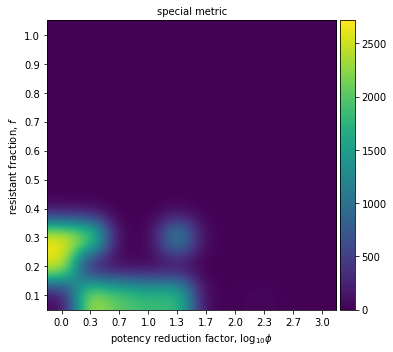

In [7]:
#try more exotic functions!

#loop through and make heatmaps
plt.figure(figsize=(6,5))
pout=np.zeros([nts,nts])
for iit1 in range(nts):
    for iit2 in range(nts):
        iz=iit2+nts*iit1
        
        pout[iit2,iit1]=gog[0,iz]*gog[3,iz]**2/(gog[4,iz]+1e-3)
        
im=plt.imshow(pout,origin='lower',interpolation='gaussian')#vmin=min(ytickz[o]),vmax=max(ytickz[o]))
plt.xticks(range(nts),np.round(np.log10(iv),1),fontsize=10)
plt.yticks(range(nts),np.round(rf,1),fontsize=10)
plt.xlabel(long_varz_labels[0])
plt.ylabel(long_varz_labels[1])
plt.title('special metric',fontsize=10)

ax=plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb=plt.colorbar(im, cax=cax)

plt.tight_layout()
plt.savefig('figures/global/specialheatmap.pdf',dpi=600)
